In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]-b[i])#/(a[i]+b[i])*10**4
    return bas

In [3]:
lob_data=utils.caricaLOB('msft',1)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].pct_change().fillna(0).copy()
b=pd.DataFrame(baSpread(lob_data),columns=['spread'])


In [4]:
spread=b['spread'].to_numpy()
d=np.log(b).diff().fillna(0).to_numpy().flatten()
hot=np.zeros(len(d))
for i in range(0,len(hot)):
    if spread[i]>0.02: #spread[i]-spread[i-1]>0.03:
        hot[i]=1 #se spread[i]>soglia up
    else: #-spread[i-1]<0.02:
        hot[i]=0 #se spread[i]<soglia lo
#plt.plot(hot);

CNN-LSTM Classifier
===

In [5]:
def prepare_x_y(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6,1)

    Y = np_utils.to_categorical(y.astype(int),2)

    return X,Y

In [6]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX,trainY = prepare_x_y  (n_train)    
valiX ,valiY  = prepare_x_y  (n_vali )    
testX ,testY  = prepare_x_y  (n_test )   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(629045, 100, 6, 1) (629045, 2)
(209615, 100, 6, 1) (209615, 2)
(209615, 100, 6, 1) (209615, 2)


In [7]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(2, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model
checkpoint_filepath = './model_tensorflow2/weights_class'
deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [8]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [24]:
deeplob.load_weights('modelMSFTClassification.h5')
#simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])

In [25]:
P = deeplob.predict(testX)
pj= np.round(P)
P

6551/6551 [==============================] - 105s 16ms/step


array([[0.7571825 , 0.24281758],
       [0.98291093, 0.01708907],
       [0.99522924, 0.00477072],
       ...,
       [0.9852985 , 0.01470145],
       [0.98245025, 0.01754982],
       [0.8277406 , 0.17225942]], dtype=float32)

In [11]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(pj, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(pj, axis=1), digits=4))

accuracy_score: 0.036514562412041124
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.0365    0.0705    209615

    accuracy                         0.0365    209615
   macro avg     0.5000    0.0183    0.0352    209615
weighted avg     1.0000    0.0365    0.0705    209615



c:\Users\macri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


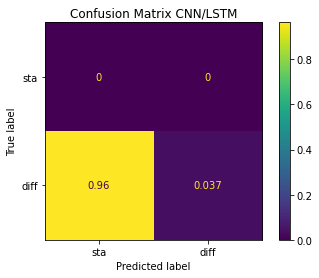

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','diff'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");

LSTM classifier
===

In [13]:
def prepare_x_y_lstm(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6)

    Y = np_utils.to_categorical(y.astype(int),2)

    return X,Y

In [14]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX_lstm,trainY_lstm = prepare_x_y_lstm  (n_train)    
valiX_lstm,valiY_lstm = prepare_x_y_lstm  (n_vali )    
testX_lstm,testY_lstm = prepare_x_y_lstm  (n_test )   


print(trainX_lstm.shape ,trainY_lstm .shape)
print(valiX_lstm.shape  ,valiY_lstm .shape)
print(testX_lstm.shape  ,testY_lstm .shape)

(629045, 100, 6) (629045, 2)
(209615, 100, 6) (209615, 2)
(209615, 100, 6) (209615, 2)


In [15]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'categorical_crossentropy'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.2)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function, metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           18176     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 100, 64)           0   

In [16]:
model.load_weights('classifyLSTM.h5')
#lstmMSFT=model.fit(trainX_lstm, trainY_lstm, validation_data=(valiX_lstm, valiY_lstm), epochs=20, batch_size=256)

In [17]:
P_lstm = model.predict(testX_lstm)
p_lstmj= np.round(P_lstm)
P_lstm

6551/6551 [==============================] - 123s 19ms/step


array([[0.6987295 , 0.30127046],
       [0.97649086, 0.02350915],
       [0.99525625, 0.00474379],
       ...,
       [0.9615083 , 0.03849173],
       [0.9802786 , 0.01972132],
       [0.7312262 , 0.26877376]], dtype=float32)

In [18]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1)))
print(classification_report(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1), digits=4))

accuracy_score: 0.05493881640149798
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.0549    0.1042    209615

    accuracy                         0.0549    209615
   macro avg     0.5000    0.0275    0.0521    209615
weighted avg     1.0000    0.0549    0.1042    209615



c:\Users\macri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


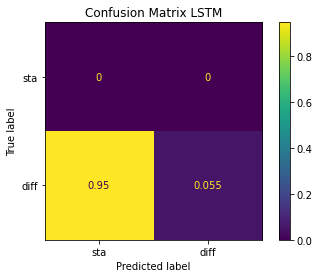

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','diff'])
disp.plot()
disp.ax_.set_title("Confusion Matrix LSTM");

Naive Gaussian Classifier
===

In [20]:
rng = np.random.RandomState(1)
X = n_train[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
y = n_train['h'].to_numpy()
Xte = n_vali[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
Yte = n_vali['h'].to_numpy()#['h'].to_numpy()
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
clf = GaussianNB()
clf.fit(X, y)
predNB = clf.predict(Xte)
encPr=np_utils.to_categorical(predNB)
#encTe=np_utils.to_categorical(Yte)
print(predNB,Yte)

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. ... 1. 1. 1.]


In [21]:
encTe=np_utils.to_categorical(n_vali['h'].to_numpy())

In [22]:
print('accuracy_score:', accuracy_score(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1)))
print(classification_report(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1), digits=4))

accuracy_score: 1.0
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000    209715

    accuracy                         1.0000    209715
   macro avg     1.0000    1.0000    1.0000    209715
weighted avg     1.0000    1.0000    1.0000    209715



ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

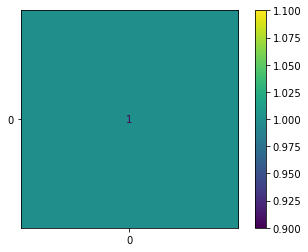

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['stats','diff'])
disp.plot()
disp.ax_.set_title("Confusion Matrix Naive");

1) Precision is a measure of how many of the positive predictions made are correct (true positives).
2) Accuracy describes the number of correct predictions over all predictions (TP+TN)/sizePop.
3) Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.
4) F1 provides a single metric that weights the two ratios (precision and recall) in a balanced way.
    - Very small precision or recall will result in lower overall score. Thus it helps balance the two metrics.
    - If you choose your positive class as the one with fewer samples, F1-score can help balance the metric across positive/negative samples.